# Example 1: Two plants, constant supply curves
_______

This illustrates storage impact in a 2 power plant/2 time slot system with constant supply curves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import symenergy.core.model as model
import symenergy.evaluator.evaluator as evaluator

pd.options.mode.chained_assignment = None

> 11:02:07 - WARNING - symenergy.core.model - !!! Monkey-patching sympy.linsolve !!!


## Initialize model
The model structure is initialized.

Parameter values are insignificant at this stage as long as they are !=None. They represent default values and define the model structure.

`Model.generate_solve()` loads the solved model results from the corresponding pickle file if a model with the same structure (variables and multipliers) has been solved before.

`nthread` is the number of cores used for parallelized solving.

In [3]:
from symenergy import logger
logger.setLevel('DEBUG')
m = model.Model(curtailment=True, nthreads=7)

m.add_slot(name='day', load=4.5, vre=3)
m.add_slot(name='night', load=5, vre=0.5)

m.add_plant(name='n', vc0=10, capacity=3500, fcom=9, cap_ret=True)
m.add_plant(name='g', vc0=90)

m.add_storage(name='phs', eff=0.75, capacity=1, energy_capacity=1,
              slots_map={'chg': ['day'] , 'dch': ['night']})

#m.cache.delete()
m.generate_solve()

> 11:02:41 - INFO - symenergy.core.asset - Variable p has time dependence True
> 11:02:41 - INFO - symenergy.core.asset - Variable p has time dependence True
> 11:02:41 - INFO - symenergy.core.asset - Variable C_ret has time dependence False
> 11:02:41 - INFO - symenergy.core.asset - Variable C_ret has time dependence False
> 11:02:41 - INFO - symenergy.core.asset - Variable p has time dependence True
> 11:02:41 - INFO - symenergy.core.asset - Variable C_ret has time dependence False
> 11:02:41 - DEBUG - symenergy.core.model - Auto-adding curtailment
> 11:02:41 - DEBUG - symenergy.core.model - _add_curtailment with slots={'day': Slot `day`, 'night': Slot `night`}
> 11:02:41 - INFO - symenergy.core.asset - Variable p has time dependence True
> 11:02:41 - INFO - symenergy.core.asset - Variable p has time dependence True
> 11:02:42 - DEBUG - symenergy.core.asset - Generating asset hash.
> 11:02:42 - DEBUG - symenergy.core.asset - Generating asset hash.
> 11:02:42 - INFO - symenergy.core.a

> 11:02:42 - INFO - symenergy.auxiliary.constrcomb - Init CstrCombBase "Full storage stays full w/o discharging_1"
> 11:02:42 - DEBUG - symenergy.auxiliary.constrcomb - {'lasts', 'this', 'anyprev'}
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - ... expanded to 0 column combinations: []
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - Init CstrCombBase "Not full storage can't become full w/out charging"
> 11:02:43 - DEBUG - symenergy.auxiliary.constrcomb - {'last', 'this'}
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - ... expanded to 0 column combinations: []
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - Init CstrCombBase "Not empty storage can't become empty w/out discharging"
> 11:02:43 - DEBUG - symenergy.auxiliary.constrcomb - {'last', 'this'}
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - ... expanded to 0 column combinations: []
> 11:02:43 - INFO - symenergy.auxiliary.constrcomb - Init CstrCombBase "Empty storage can`t discharge"
> 11:02:43 - DEBUG - 

> 11:05:20 - INFO - symenergy.auxiliary.parallelization - Solve: 826/1736 (47.6%), chunksize 124, ForkPoolWorker-19
> 11:05:27 - INFO - symenergy.auxiliary.parallelization - Solve: 861/1736 (49.6%), chunksize 124, ForkPoolWorker-16
> 11:05:27 - INFO - symenergy.auxiliary.parallelization - Solve: 863/1736 (49.7%), chunksize 124, ForkPoolWorker-15
> 11:05:29 - INFO - symenergy.auxiliary.parallelization - Solve: 868/1736 (50.0%), chunksize 124, ForkPoolWorker-20
> 11:05:30 - INFO - symenergy.auxiliary.parallelization - Solve: 871/1736 (50.2%), chunksize 124, ForkPoolWorker-18
> 11:05:39 - INFO - symenergy.auxiliary.parallelization - Solve: 922/1736 (53.1%), chunksize 124, ForkPoolWorker-21
> 11:07:52 - INFO - symenergy.auxiliary.parallelization - Solve: 1684/1736 (97.0%), chunksize 124, ForkPoolWorker-15
> 11:07:54 - INFO - symenergy.auxiliary.parallelization - Solve: 1689/1736 (97.3%), chunksize 124, ForkPoolWorker-17
> 11:07:58 - INFO - symenergy.auxiliary.parallelization - Solve: 1712/

> 11:08:07 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pdch_night contained variabs pi_phs_pwrerg_dch_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:07 - DEBUG - symenergy.core.model - idx=823
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pchg_day contained variabs pi_phs_pwrerg_chg_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pdch_night contained variabs pi_phs_pwrerg_dch_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_dch_none contained variabs pi_phs_pwrerg_dch_none.
> 11:08:07 - DEBUG - symenergy.core.model -      Solution for pi

> 11:08:08 - DEBUG - symenergy.core.model - idx=1167
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pdch_night contained variabs pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model - idx=189
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_e_none contained variabs pi_phs_pwrerg_chg_none, pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_e_none contained variabs pi_phs_pwrerg_chg_none, pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model - idx=665
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pdch_night contained variabs pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model -  

> 11:08:08 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pchg_day contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_chg_none contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for pi_phs_pwrerg_dch_none contained variabs pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pchg_day contained variabs pi_phs_pwrerg_chg_none.
> 11:08:08 - DEBUG - symenergy.core.model - idx=1377
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_pdch_night contained variabs pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model -      Solution for lb_phs_pos_e_none contained variabs pi_phs_pwrerg_chg_none, pi_phs_pwrerg_dch_none.
> 11:08:08 - DEBUG - symenergy.core.model -   

> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 50/71 (70.4%), chunksize 5, ForkPoolWorker-35
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 55/71 (77.5%), chunksize 5, ForkPoolWorker-29
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 63/71 (88.7%), chunksize 5, ForkPoolWorker-30
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 66/71 (93.0%), chunksize 5, ForkPoolWorker-32
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 67/71 (94.4%), chunksize 5, ForkPoolWorker-34
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 69/71 (97.2%), chunksize 5, ForkPoolWorker-31
> 11:08:10 - INFO - symenergy.auxiliary.parallelization - Substituting total cost: 71/71 (100.0%), chunksize 5, ForkPoolWorker-33
> 11:08:11 - INFO - symenergy.auxiliary.parallelization - parallelize_df: concatenating ... 
> 1

## Adjust model parameters
Model parameters can be freely adjusted prior to the :class:`sympy.Evaluator` initialization. 

In [4]:
vre_day = 1
vre_night = 0.1
tot_l = m.slots['day'].l.value + m.slots['night'].l.value

m.slots['day'].vre.value = vre_day / (vre_day + vre_night) * tot_l
m.slots['night'].vre.value = vre_night / (vre_day + vre_night) * tot_l

dd_75 = 14  # discharge duration for long-term storage
dd_90 = 4   # discharge duration for short-term storage

phs_C_max = m.slots['day'].l.value * 0.5  # maximum

## Initialize evaluator instance, set model parameters and parameter sweep values.
The model results are evaluated for all combinations of the iterables' values in the `x_vals` argument.

The `Evaluator.df_x_vals` instance attribute is modified after initialization to
* filter model runs
* set the storage energy capacity `E_phs` in dependence on the efficiency `eff_phs` (i.e. the storage type)

In [5]:
x_vals_vre = {m.vre_scale: np.linspace(0, 1, 21),
              m.comps['phs'].C: [0, 2600],
              m.comps['phs'].E: [None], # <-- set later
              m.comps['phs'].eff: [0.75, 0.9],
              m.comps['n'].C: [2000, 4000, 5000],
              }

ev = evaluator.Evaluator(m, x_vals_vre, drop_non_optimum=False)
ev.cache_lambd.delete()

> 10:38:50 - WARNING - symenergy.auxiliary.io - **********************************************************************
> 10:38:50 - WARNING - symenergy.auxiliary.io - **********************************************************************
> 10:38:50 - WARNING - symenergy.auxiliary.io - Loading from cache file symenergy/cache/A44997457564.pickle.
> 10:38:50 - WARNING - symenergy.auxiliary.io - Please delete this file to re-evaluate: Evaluator.cache_lambd.delete()
> 10:38:50 - WARNING - symenergy.auxiliary.io - **********************************************************************
> 10:38:50 - WARNING - symenergy.auxiliary.io - **********************************************************************


## Adjust values for model evaluation
The `df_x_vals` attribute is a dataframe containing all parameter value combinations for which the model is to be evaluated. It can be modified prior to the call 

In [6]:
ev.df_x_vals['E_phs_none'] = ev.df_x_vals.C_phs_none
ev.df_x_vals.loc[ev.df_x_vals.eff_phs_none == 0.90, 'E_phs_none'] *= dd_90/12
ev.df_x_vals.loc[ev.df_x_vals.eff_phs_none == 0.75, 'E_phs_none'] *= dd_75/12

mask_vre = (ev.df_x_vals.vre_scale_none.isin(np.linspace(0, 1, 11))
            | ev.df_x_vals.vre_scale_none.isin(np.linspace(0.55, 0.75, 21)))
mask_phs = (ev.df_x_vals.C_phs_none.isin(np.linspace(0, phs_C_max, 6)))

ev.df_x_vals = ev.df_x_vals.loc[mask_vre | mask_phs]

print(ev.df_x_vals.head(10))
print('Length: ', len(ev.df_x_vals))

   vre_scale_none  C_phs_none   E_phs_none  eff_phs_none  C_n_none
0             0.0           0     0.000000          0.75      2000
1             0.0           0     0.000000          0.75      4000
2             0.0           0     0.000000          0.75      5000
3             0.0           0     0.000000          0.90      2000
4             0.0           0     0.000000          0.90      4000
5             0.0           0     0.000000          0.90      5000
6             0.0        2600  3033.333333          0.75      2000
7             0.0        2600  3033.333333          0.75      4000
8             0.0        2600  3033.333333          0.75      5000
9             0.0        2600   866.666667          0.90      2000
Length:  210


## Evaluate results for all entries of the `Evaluator.df_x_vals table`
**Note: Depending on the size of the model and the `df_x_vals` table this takes a while.**

In [7]:
ev.cache_eval.delete()
ev.expand_to_x_vals_parallel()

> 10:38:58 - WARNING - symenergy.evaluator.evaluator - _call_eval: Generating dataframe with length 193830


## Add additional columns to the `Evaluator.df_exp` table
Variables are not indexed by time slot names. The `Evaluator.map_func_to_slot` method expands the `Evaluator.df_exp` table by additional columns with variable names and time slots names.

In [8]:
ev.map_func_to_slot()

AttributeError: 'Evaluator' object has no attribute 'map_func_to_slot'

## Build supply table `Evaluator.df_bal`
This includes the demand to the result demand and adjusts the signs, such that demand, charging, and curtailment are negative. 


In [9]:
ev.build_supply_table()

print(ev.df_bal.head(5))

       C_n_none  C_phs_none  E_phs_none  eff_phs_none        func  \
69822      2000           0         0.0          0.75  curt_p_day   
69834      2000           0         0.0          0.75  curt_p_day   
69846      2000           0         0.0          0.75  curt_p_day   
69858      2000           0         0.0          0.75  curt_p_day   
69870      2000           0         0.0          0.75  curt_p_day   

      func_no_slot  idx     lambd pwrerg slot  vre_scale_none  
69822       curt_p  627 -0.250000    pwr  day            0.55  
69834       curt_p  627 -0.681818    pwr  day            0.60  
69846       curt_p  627 -1.113636    pwr  day            0.65  
69858       curt_p  627 -1.545455    pwr  day            0.70  
69870       curt_p  627 -1.977273    pwr  day            0.75  


In [13]:
from bokeh.io import show
from bokeh.plotting import output_notebook
import symenergy.evaluator.plotting as plotting

output_notebook()

balplot = plotting.BalancePlot(ev=ev, ind_axx='vre_scale_none', ind_pltx='slot', ind_plty=None)

balplot.cds_pos.data

show(balplot._get_layout())


Loading BokehJS ...

## Simple energy balance plot with and without storage for day and night


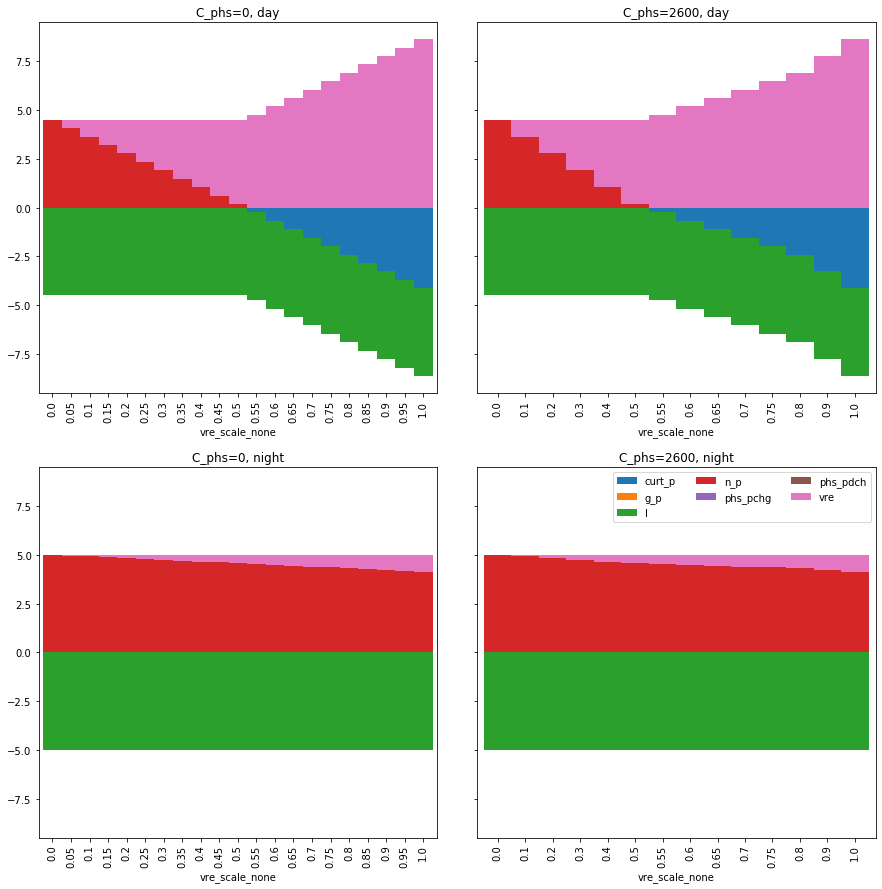

In [14]:
df = ev.df_bal
df = df.loc[-df.func_no_slot.str.contains('tc', 'lam')
           & df.eff_phs_none.isin([0.75])
           & df.C_n_none.isin([5000])
           & -df.slot.isin(['global'])]

df['lambd'] = df.lambd.astype(float)
df['vre_scale_none'] = df.vre_scale_none.apply(lambda x: round(x*10000)/10000)


dfpv = df.pivot_table(columns='func_no_slot', values='lambd', index=['C_phs_none', 'slot', 'vre_scale_none'])

list_slot = dfpv.index.get_level_values('slot').unique()
list_c_phs = dfpv.index.get_level_values('C_phs_none').unique()

fig, axarr = plt.subplots(len(list_c_phs),
                          len(list_slot), sharey=True, gridspec_kw={'wspace': 0.1,}, figsize=(15,15))

for nslot, slot in enumerate(list_slot):
    for nc_phs, c_phs in enumerate(list_c_phs):

        ax = axarr[nslot][nc_phs]
        dfpv.loc[(c_phs, slot)].plot.bar(ax=ax, legend=False, use_index=True, stacked=True, width=1)
        
        ax.set_title('C_phs=%s, %s'%(c_phs, slot))

        
leg = ax.legend(ncol=3)        



## Impact of storage on baseload production by constraint combination

In [28]:
df = ev.df_exp
df = df.loc[df.func.str.contains('n_p_')
           & df.is_optimum.isin([True])
           & -df.slot.isin(['global'])]

df.head(5)

dfdiff = df.pivot_table(index=[x for x in ev.x_name if not x in ['E_phs_none', 'C_phs_none']] + ['func'],
                        values='lambd', columns='C_phs_none')
dfdiff['diff'] = dfdiff[2600] - dfdiff[0]
#
#dfcc = df.loc[df.C_phs_none == 2600].set_index(dfdiff.index.names)['idx']
#dfdiff = dfdiff.reset_index().join(dfcc, on=dfdiff.index.names)

dfdiff

C_phs_none                                             0      2600  diff
vre_scale_none eff_phs_none C_n_none func                               
0.0            0.75         2000     n_p_day    4.500000  4.500000   0.0
                                     n_p_night  5.000000  5.000000   0.0
                            4000     n_p_day    4.500000  4.500000   0.0
                                     n_p_night  5.000000  5.000000   0.0
                            5000     n_p_day    4.500000  4.500000   0.0
...                                                  ...       ...   ...
1.0            0.90         2000     n_p_night  4.136364  4.136364   0.0
                            4000     n_p_day    0.000000  0.000000   0.0
                                     n_p_night  4.136364  4.136364   0.0
                            5000     n_p_day    0.000000  0.000000   0.0
                                     n_p_night  4.136364  4.136364   0.0

[252 rows x 3 columns]

In [25]:
#dfpv = dfdiff.pivot_table(index=['eff_phs_none', 'C_n_none', 'vre_scale_none'], 
#                          columns='idx', values='diff')
#
#list_eff = dfpv.index.get_level_values('eff_phs_none').unique()
#list_c_n = dfpv.index.get_level_values('C_n_none').unique()
#
#fig, axarr = plt.subplots(len(list_eff), len(list_c_n), 
#                          sharey=True, gridspec_kw={'wspace': 0.1,}, figsize=(15,15))
#
#for neff, eff in enumerate(list_eff):
#    for nc_n, c_n in enumerate(list_c_n):
#
#        ax = axarr[neff][nc_n] if isinstance(axarr, np.ndarray) else axarr
#        dfpv.loc[(eff, c_n)].plot(ax=ax, legend=False, marker='.',use_index=True, stacked=False, linewidth=1)
#        
#        ax.set_title('C_phs_none=%s, %s'%(eff, c_n))
#        ax.set_ylabel('Storage impact')